<a href="https://colab.research.google.com/github/Fa1tumn/glove_matrix/blob/main/problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. GloVe를 위한 동시출현 행렬 구축

이 노트북에서는 GloVe(Global Vectors for Word Representation) 모델 구현을 위한 동시출현 행렬(Co-occurrence Matrix)을 구축합니다.

## 학습 목표
- 단어 동시출현 행렬의 개념 이해하기
- 윈도우 기반 동시출현 행렬 구축하기
- 희소 행렬(sparse matrix)을 사용하여 메모리 효율적으로 저장하기
- 동시출현 통계 시각화 및 분석하기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy.sparse as sparse
from collections import defaultdict, Counter
import seaborn as sns

# 시각화 설정
plt.style.use('ggplot')
%matplotlib inline

## 3.1 전처리 결과 불러오기

이전 노트북에서 저장한 전처리 결과와 n-gram 결과를 불러옵니다.

In [8]:
# 전처리 결과 불러오기
try:
    with open('preprocessing_results.pkl', 'rb') as f:
        preprocessing_results = pickle.load(f)

    tokenized_corpus = preprocessing_results['tokenized_corpus']
    word_to_id = preprocessing_results['word_to_id']
    id_to_word = preprocessing_results['id_to_word']
    word_counts = preprocessing_results['word_counts']

    print("전처리 결과를 성공적으로 불러왔습니다.")
    print(f"어휘 사전 크기: {len(word_to_id)} 단어")
    print(f"문장 수: {len(tokenized_corpus)}")
except FileNotFoundError:
    print("전처리 결과 파일을 찾을 수 없습니다. 먼저 '1_corpus_preprocessing.ipynb'를 실행해주세요.")

# n-gram 결과 불러오기 (옵션)
try:
    with open('ngram_results.pkl', 'rb') as f:
        ngram_results = pickle.load(f)

    bigrams = ngram_results['bigrams']
    print("n-gram 결과를 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("n-gram 결과 파일을 찾을 수 없습니다. 필요한 경우 '2_ngram_model.ipynb'를 실행해주세요.")

전처리 결과를 성공적으로 불러왔습니다.
어휘 사전 크기: 59 단어
문장 수: 10
n-gram 결과 파일을 찾을 수 없습니다. 필요한 경우 '2_ngram_model.ipynb'를 실행해주세요.


## 3.2 GloVe 동시출현 행렬 구축

GloVe 모델에서는 단어의 동시출현(co-occurrence) 통계를 사용합니다. 이는 n-gram 모델에서 사용한 동시출현 행렬과 유사하지만, 윈도우 크기가 다를 수 있습니다.

이 구현에서는 다음 단계로 동시출현 행렬을 구축합니다:
1. 모든 문장에 대해 이동 윈도우(sliding window)를 적용
2. 윈도우 내의 모든 단어 쌍에 대해 동시출현 빈도 계산
3. 중심 단어로부터의 거리에 따라 가중치 적용 (거리가 멀수록 낮은 가중치)

In [10]:
def build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size=2):
    """GloVe 모델을 위한 동시출현 행렬을 구축하는 함수

    Args:
        tokenized_corpus: 토큰화된 말뭉치
        word_to_id: 단어-ID 매핑 딕셔너리
        window_size: 중심 단어 좌우의 윈도우 크기

    Returns:
        희소 행렬 형태의 동시출현 행렬
    """
    vocab_size = len(word_to_id)
    cooccurrence_dict = defaultdict(float)

    # 모든 문장에 대해 반복
    for sentence in tokenized_corpus:
        # 문장의 길이
        sentence_length = len(sentence)

        # 문장의 각 위치에 대해 반복
        for i, center_word in enumerate(sentence):
            # 중심 단어가 어휘 사전에 없는 경우 건너뜀
            if center_word not in word_to_id:
                continue

            center_id = word_to_id[center_word]

            # 윈도우 내의 단어들에 대해 반복
            window_start = max(0, i - window_size)
            window_end = min(sentence_length, i + window_size + 1)

            for j in range(window_start, window_end):
                # 중심 단어 자신은 건너뜀
                if i == j:
                    continue

                context_word = sentence[j]

                # 문맥 단어가 어휘 사전에 없는 경우 건너뜀
                if context_word not in word_to_id:
                    continue

                context_id = word_to_id[context_word]

                # 거리에 따른 가중치 계산 (거리가 멀수록 낮은 가중치)
                distance = abs(j - i)
                weight = 1.0 / distance

                # 동시출현 빈도 증가 (가중치 적용)
                cooccurrence_dict[(center_id, context_id)] += weight

    # 희소 행렬 생성을 위한 데이터 준비
    row_indices = []
    col_indices = []
    data = []

    for (i, j), value in cooccurrence_dict.items():
        row_indices.append(i)
        col_indices.append(j)
        data.append(value)

    # CSR 형식의 희소 행렬 생성
    cooccurrence_matrix = sparse.csr_matrix((data, (row_indices, col_indices)),
                                            shape=(vocab_size, vocab_size))

    return cooccurrence_matrix

# GloVe 동시출현 행렬 구축
window_sizes = [1,3,5] # 윈도우 크기 설정
for window_size in window_sizes:
  cooccurrence_matrix_glove = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size)
  print(f"윈도우 크기: {window_size}")
  print(f"GloVe 동시출현 행렬 크기: {cooccurrence_matrix_glove.shape}")
  print(f"총 동시출현 빈도: {cooccurrence_matrix_glove.sum():.2f}")
  print(f"0이 아닌 원소 수: {cooccurrence_matrix_glove.nnz}")
  print(f"희소성 (sparsity): {(1 - cooccurrence_matrix_glove.nnz / (cooccurrence_matrix_glove.shape[0] * cooccurrence_matrix_glove.shape[1])) * 100:.2f}%")

윈도우 크기: 1
GloVe 동시출현 행렬 크기: (59, 59)
총 동시출현 빈도: 120.00
0이 아닌 원소 수: 116
희소성 (sparsity): 96.67%
윈도우 크기: 3
GloVe 동시출현 행렬 크기: (59, 59)
총 동시출현 빈도: 196.67
0이 아닌 원소 수: 296
희소성 (sparsity): 91.50%
윈도우 크기: 5
GloVe 동시출현 행렬 크기: (59, 59)
총 동시출현 빈도: 219.67
0이 아닌 원소 수: 396
희소성 (sparsity): 88.62%


## 3.3 동시출현 통계 시각화

특정 단어들의 동시출현 패턴을 시각화합니다.

In [11]:
!pip install seaborn
import seaborn as sns


In [12]:
!pip install koreanize_matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 34.9 MB/s eta 0:00:00


윈도우 크기: 1


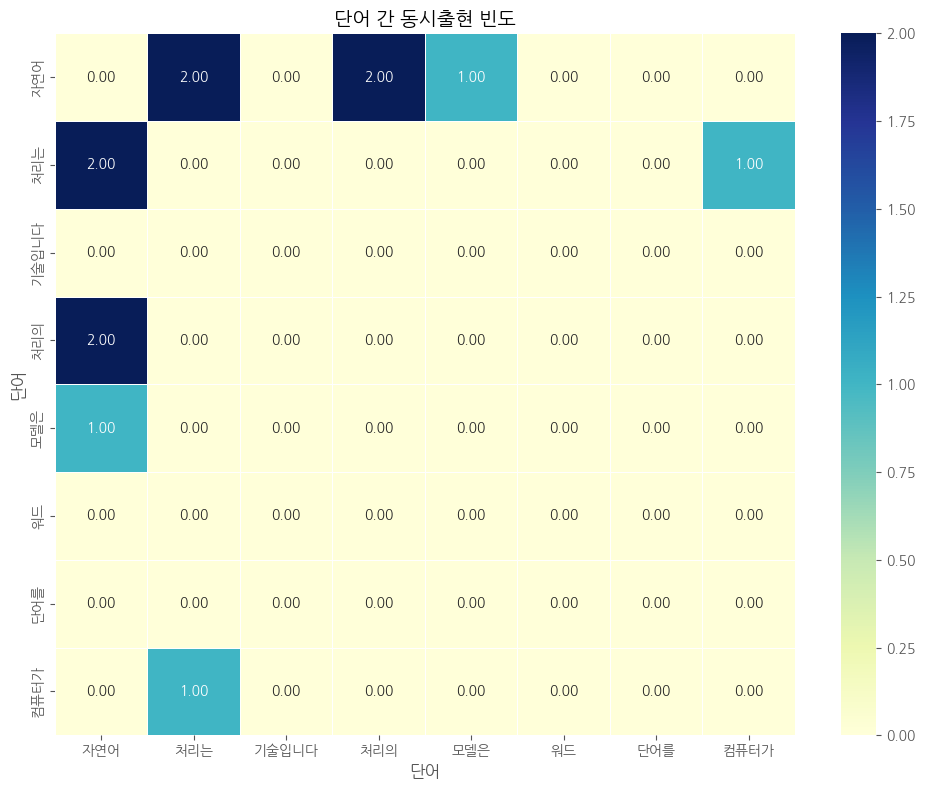

윈도우 크기: 3


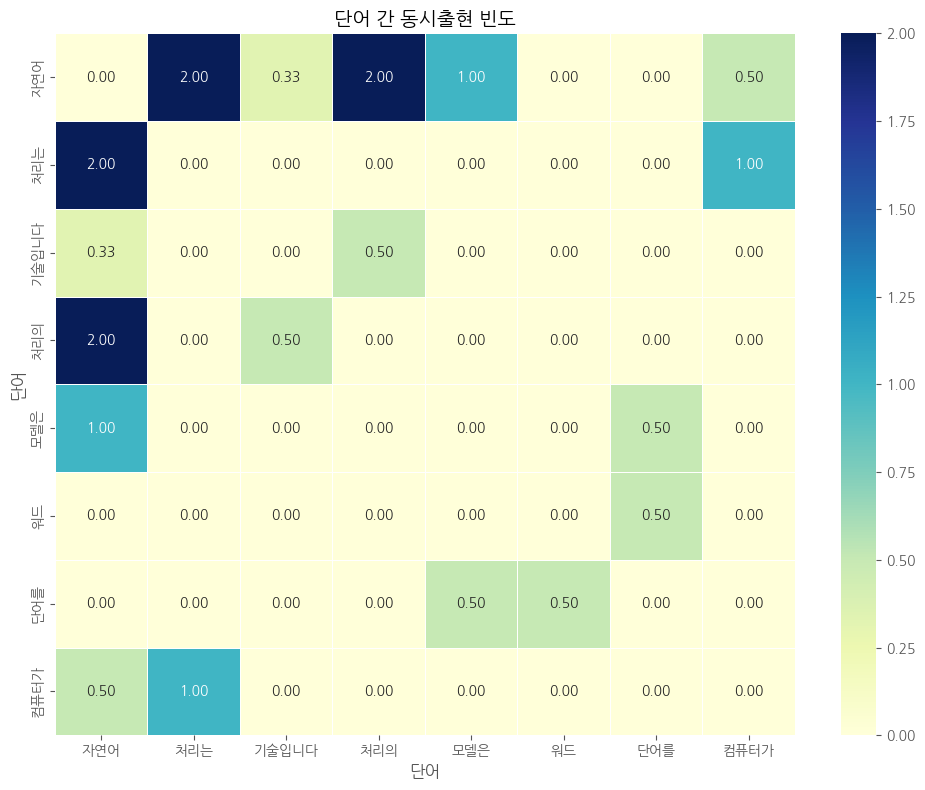

윈도우 크기: 5


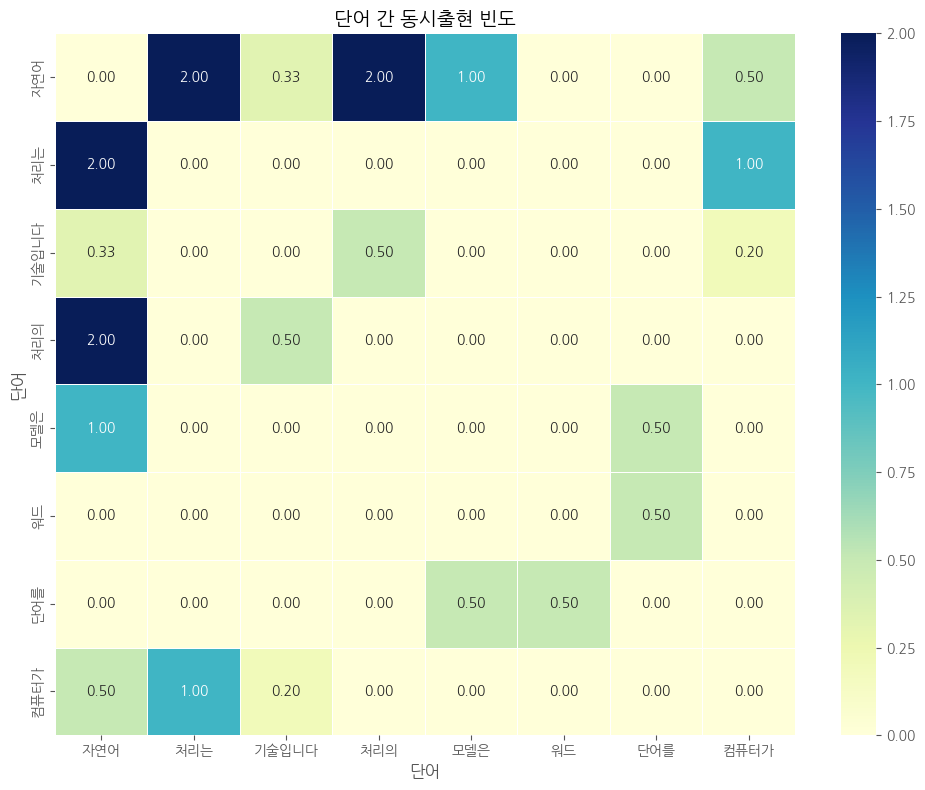

In [13]:
def visualize_cooccurrence_heatmap(cooccurrence_matrix, word_to_id, id_to_word, target_words, figsize=(10, 8)):
    """특정 단어들의 동시출현 패턴을 히트맵으로 시각화하는 함수

    Args:
        cooccurrence_matrix: 동시출현 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        target_words: 시각화할 단어 목록
        figsize: 그림 크기
    """
    # 대상 단어들의 ID 리스트
    target_ids = []
    for word in target_words:
        try:
            target_ids.append(word_to_id[word])
        except KeyError:
            print(f"단어 '{word}'를 어휘 사전에서 찾을 수 없습니다.")

    if not target_ids:
        print("시각화할 단어가 없습니다.")
        return

    # 대상 단어들만의 부분 행렬 추출
    sub_matrix = cooccurrence_matrix[target_ids, :][:, target_ids].toarray()

    # 히트맵 시각화
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(sub_matrix, annot=True, fmt=".2f", linewidths=0.5,
                xticklabels=[id_to_word[i] for i in target_ids],
                yticklabels=[id_to_word[i] for i in target_ids],
                cmap="YlGnBu", ax=ax)
    plt.title("단어 간 동시출현 빈도", fontsize=14)
    plt.xlabel("단어", fontsize=12)
    plt.ylabel("단어", fontsize=12)
    plt.tight_layout()
    plt.show()

# 특정 단어들의 동시출현 패턴 시각화
# 가장 빈번한 단어들 중 일부 선택
most_common_words = [word for word, _ in word_counts.most_common(10)]
most_common_words = [word for word, _ in word_counts.most_common(10)]
target_words = most_common_words[:8]  # 상위 8개 단어
for window_size in window_sizes:
  print(f"윈도우 크기: {window_size}")
  cooccurrence_matrix_glove = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size)
  visualize_cooccurrence_heatmap(cooccurrence_matrix_glove, word_to_id, id_to_word, target_words)

## 3.4 특정 단어 쌍의 동시출현 빈도 분석

특정 단어와 가장 자주 동시출현하는 단어들을 찾고 분석합니다.

윈도우 크기: 1

'자연어'와 가장 자주 동시출현하는 단어들:
  처리의: 2.00
  전처리는: 1.00
  처리: 1.00
  모델은: 1.00
  컴퓨터는: 1.00
  처리를: 1.00
  기계학습은: 1.00


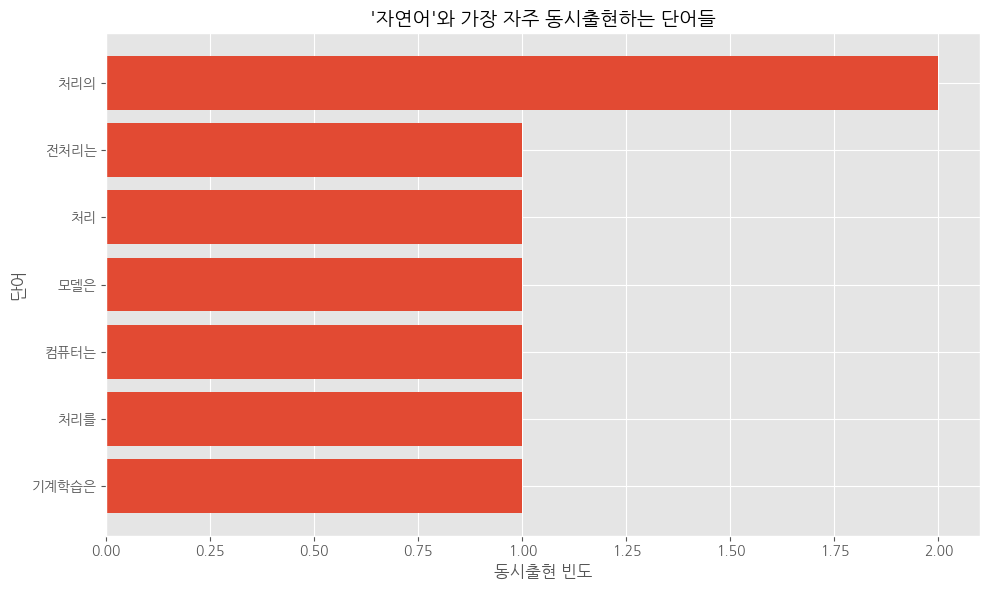

윈도우 크기: 3

'자연어'와 가장 자주 동시출현하는 단어들:
  처리의: 2.00
  전처리는: 1.00
  처리: 1.00
  모델은: 1.00
  컴퓨터는: 1.00
  처리를: 1.00
  기계학습은: 1.00
  기계: 0.50
  첫: 0.50
  텍스트: 0.50


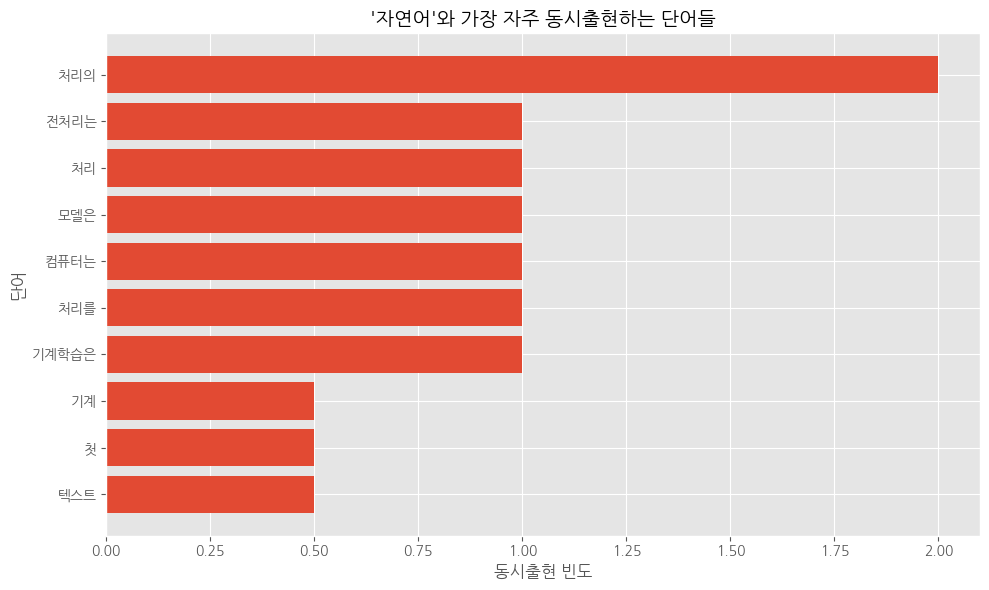

윈도우 크기: 5

'자연어'와 가장 자주 동시출현하는 단어들:
  처리의: 2.00
  전처리는: 1.00
  처리: 1.00
  모델은: 1.00
  컴퓨터는: 1.00
  처리를: 1.00
  기계학습은: 1.00
  기계: 0.50
  첫: 0.50
  텍스트: 0.50


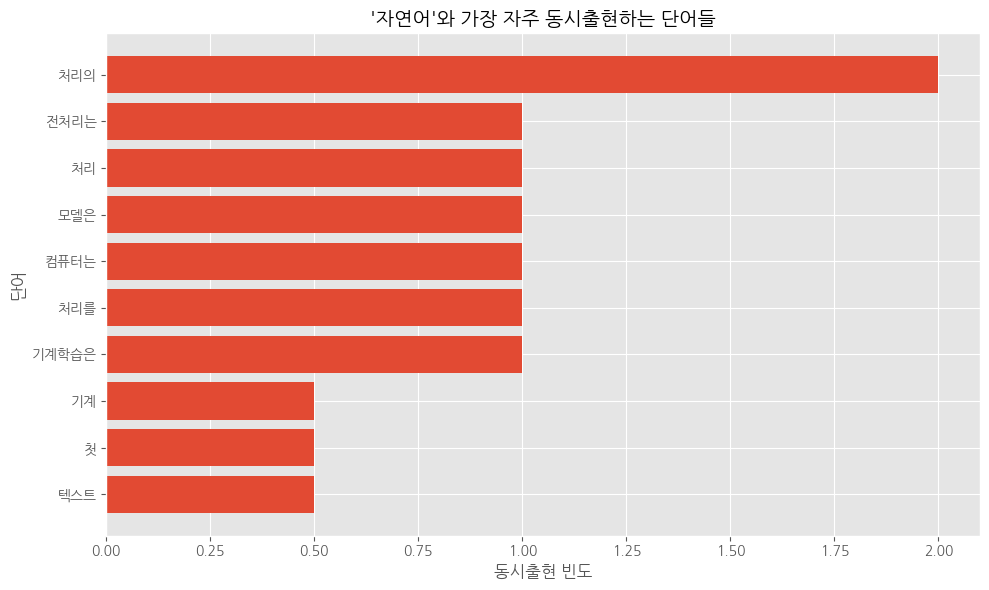

윈도우 크기: 1

'처리는'와 가장 자주 동시출현하는 단어들:
  컴퓨터가: 1.00
  기계: 1.00


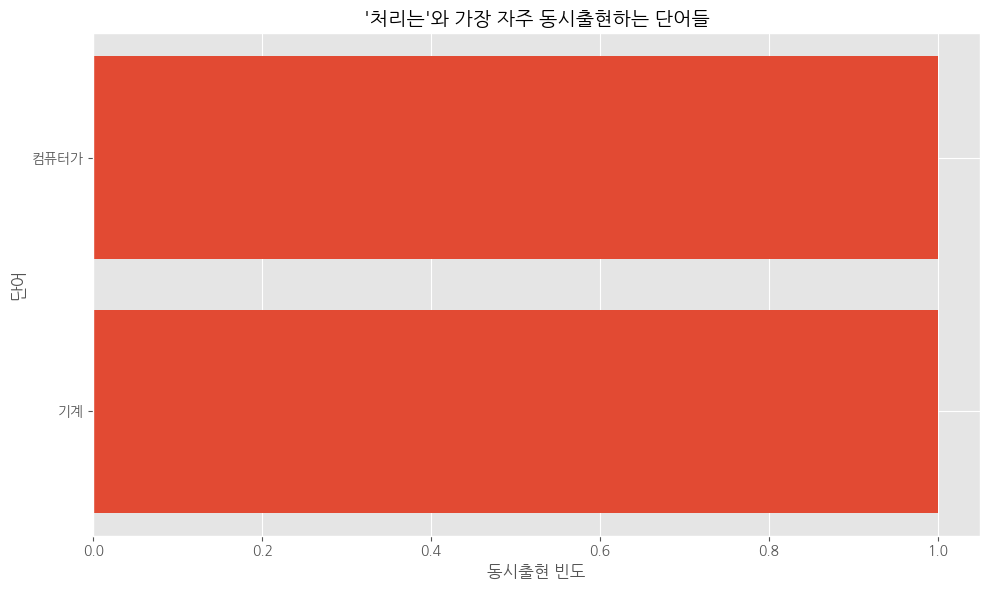

윈도우 크기: 3

'처리는'와 가장 자주 동시출현하는 단어들:
  컴퓨터가: 1.00
  기계: 1.00
  번역: 0.50
  인간의: 0.50
  언어를: 0.33
  감성: 0.33


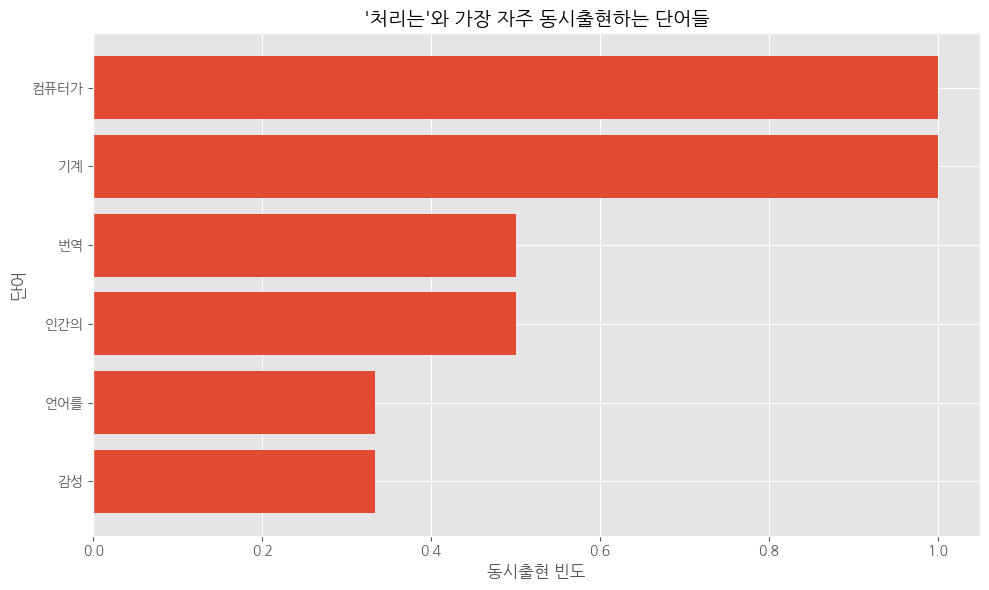

윈도우 크기: 5

'처리는'와 가장 자주 동시출현하는 단어들:
  컴퓨터가: 1.00
  기계: 1.00
  번역: 0.50
  인간의: 0.50
  언어를: 0.33
  감성: 0.33
  분석: 0.25
  이해하고: 0.25
  처리하는: 0.20
  정보: 0.20


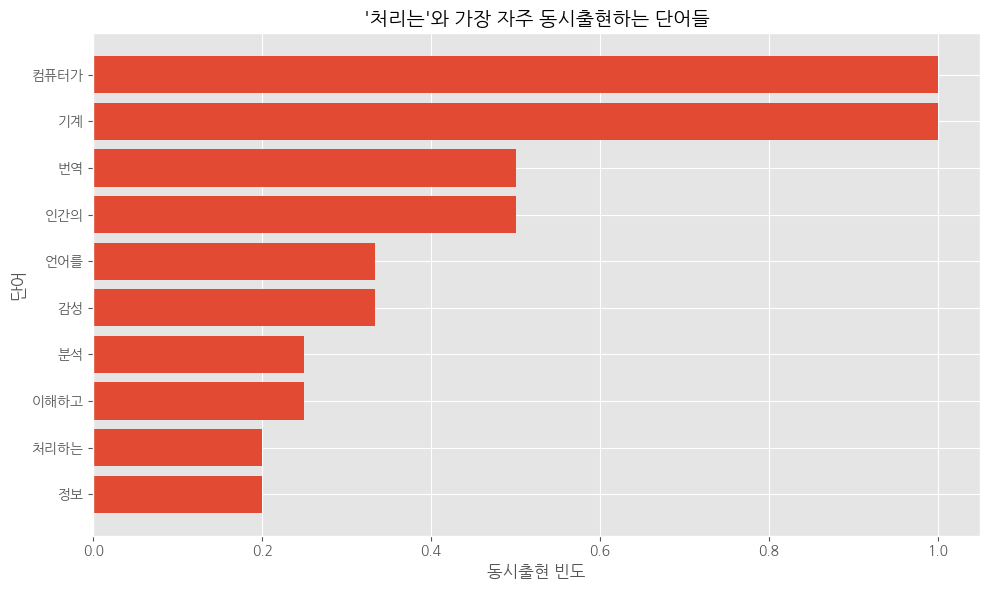

윈도우 크기: 1

'기술입니다'와 가장 자주 동시출현하는 단어들:
  처리하는: 1.00


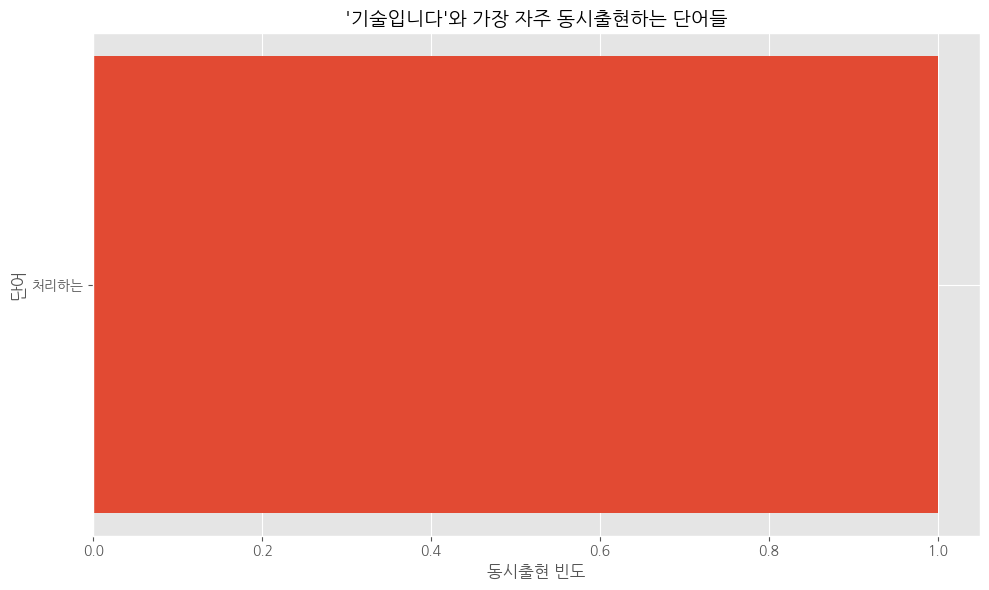

윈도우 크기: 3

'기술입니다'와 가장 자주 동시출현하는 단어들:
  처리하는: 1.00
  이해하고: 0.50
  처리의: 0.50
  언어를: 0.33
  자연어: 0.33


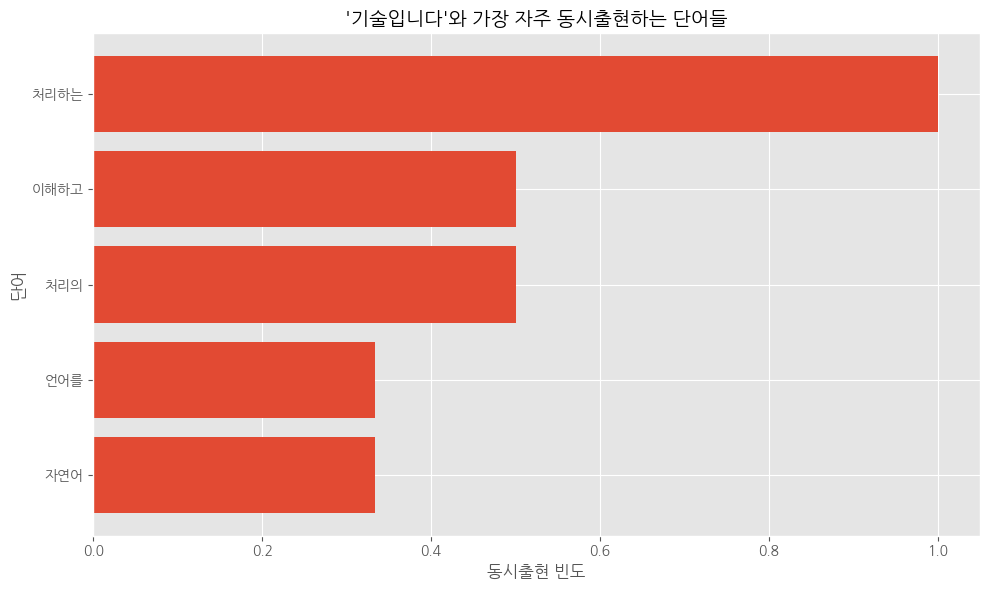

윈도우 크기: 5

'기술입니다'와 가장 자주 동시출현하는 단어들:
  처리하는: 1.00
  이해하고: 0.50
  처리의: 0.50
  언어를: 0.33
  자연어: 0.33
  인간의: 0.25
  기계학습은: 0.25
  인공지능과: 0.20
  컴퓨터가: 0.20


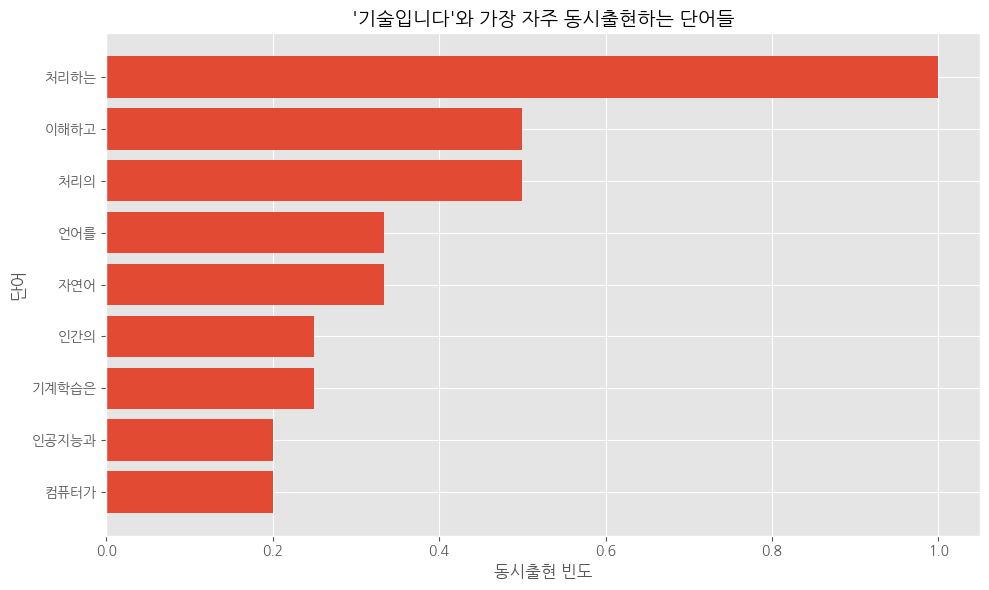

In [14]:
def find_top_cooccurring_words(word, cooccurrence_matrix, word_to_id, id_to_word, top_n=10):
    """특정 단어와 가장 자주 동시출현하는 단어들을 찾는 함수

    Args:
        word: 대상 단어
        cooccurrence_matrix: 동시출현 행렬
        word_to_id: 단어-ID 매핑 딕셔너리
        id_to_word: ID-단어 매핑 딕셔너리
        top_n: 상위 몇 개의 단어를 반환할지 결정

    Returns:
        상위 동시출현 단어와 빈도의 리스트
    """
    try:
        word_id = word_to_id[word]
    except KeyError:
        print(f"단어 '{word}'를 어휘 사전에서 찾을 수 없습니다.")
        return []

    # 해당 단어의 동시출현 벡터 추출
    cooccurrence_vec = cooccurrence_matrix[word_id].toarray().flatten()

    # 동시출현 빈도가 높은 상위 단어 인덱스 (자기 자신 제외)
    top_indices = np.argsort(cooccurrence_vec)[-top_n-1:-1][::-1]

    # 결과 생성
    result = []
    for idx in top_indices:
        if cooccurrence_vec[idx] > 0:  # 빈도가 0인 경우 제외
            result.append((id_to_word[idx], cooccurrence_vec[idx]))

    return result

def visualize_top_cooccurring_words(word, top_cooccurring, figsize=(10, 6)):
    """특정 단어와 가장 자주 동시출현하는 단어들을 막대 그래프로 시각화하는 함수"""
    if not top_cooccurring:
        return

    words, freqs = zip(*top_cooccurring)

    plt.figure(figsize=figsize)
    plt.barh(words, freqs)
    plt.title(f"'{word}'와 가장 자주 동시출현하는 단어들", fontsize=14)
    plt.xlabel('동시출현 빈도', fontsize=12)
    plt.ylabel('단어', fontsize=12)
    plt.gca().invert_yaxis()  # 빈도가 높은 단어를 위쪽에 표시
    plt.tight_layout()
    plt.show()

# 예시: 특정 단어들에 대한 동시출현 분석
example_words = most_common_words[:3]  # 상위 3개 단어
for word in example_words:
    for window_size in window_sizes:
      print(f"윈도우 크기: {window_size}")
      cooccurrence_matrix_glove = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size)
      top_cooccurring = find_top_cooccurring_words(word, cooccurrence_matrix_glove, word_to_id, id_to_word)
      print(f"\n'{word}'와 가장 자주 동시출현하는 단어들:")
      for cooccurring_word, freq in top_cooccurring:
          print(f"  {cooccurring_word}: {freq:.2f}")
      visualize_top_cooccurring_words(word, top_cooccurring)

## 3.5 동시출현 행렬의 특성 분석

동시출현 행렬의 전체적인 특성과 분포를 분석합니다.

윈도우 크기: 1
동시출현 행렬 통계:
  총 동시출현 빈도: 120.00
  0이 아닌 원소 수: 116
  최대값: 2.00
  최소값 (0 제외): 1.00
  평균값 (0 제외): 1.03
  중앙값 (0 제외): 1.00


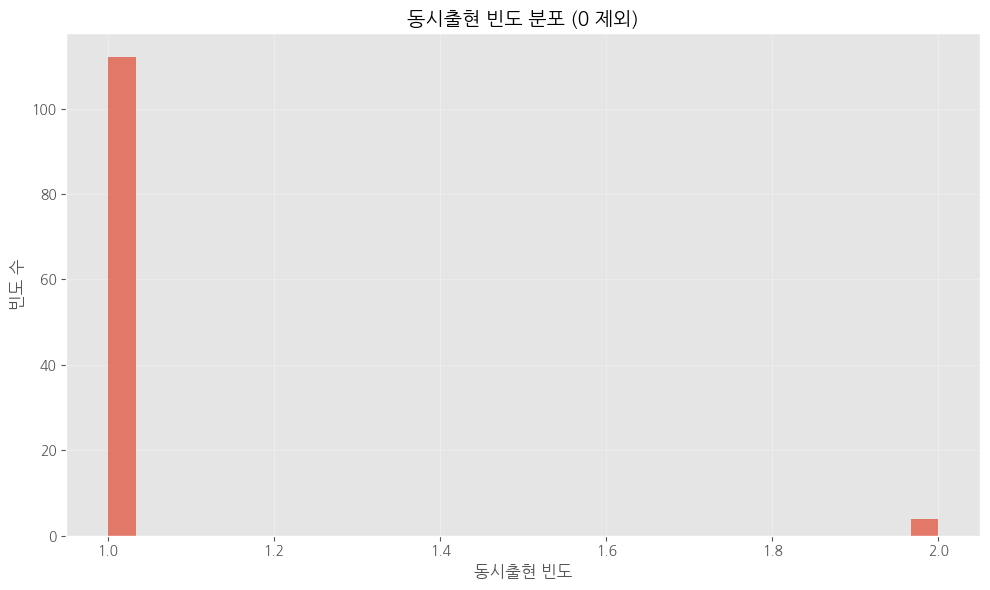

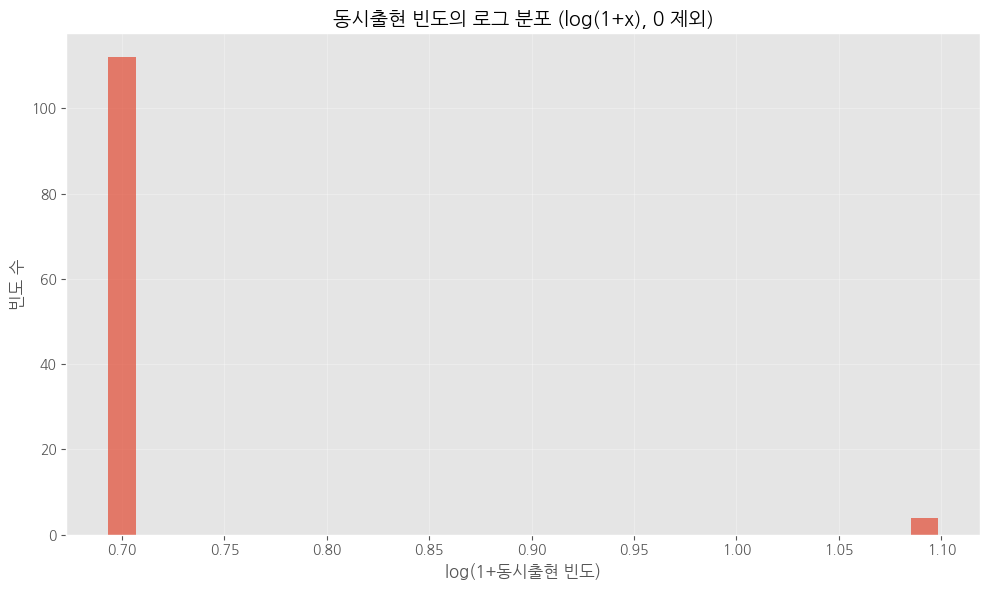

윈도우 크기: 3
동시출현 행렬 통계:
  총 동시출현 빈도: 196.67
  0이 아닌 원소 수: 296
  최대값: 2.00
  최소값 (0 제외): 0.33
  평균값 (0 제외): 0.66
  중앙값 (0 제외): 0.50


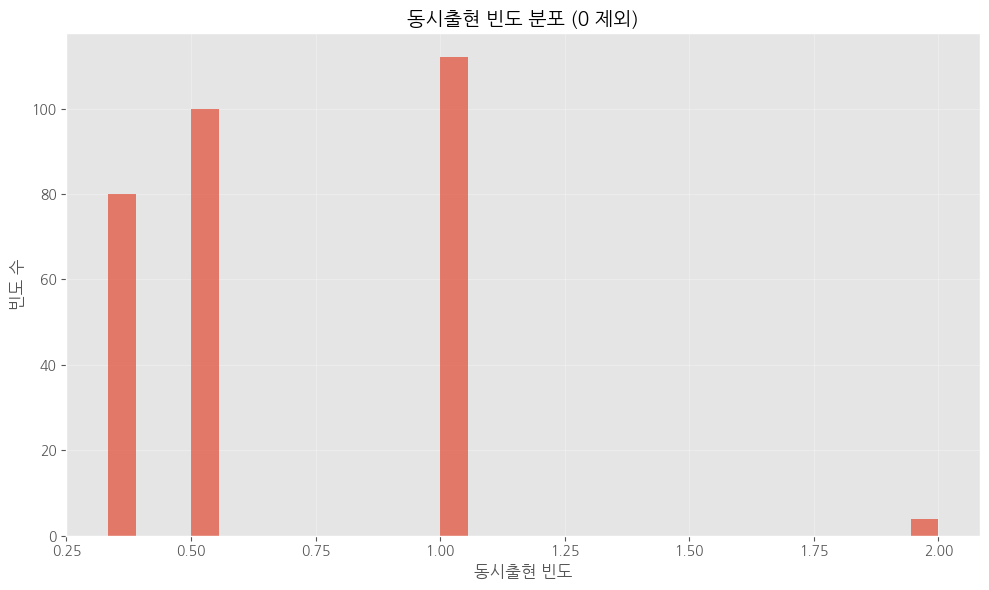

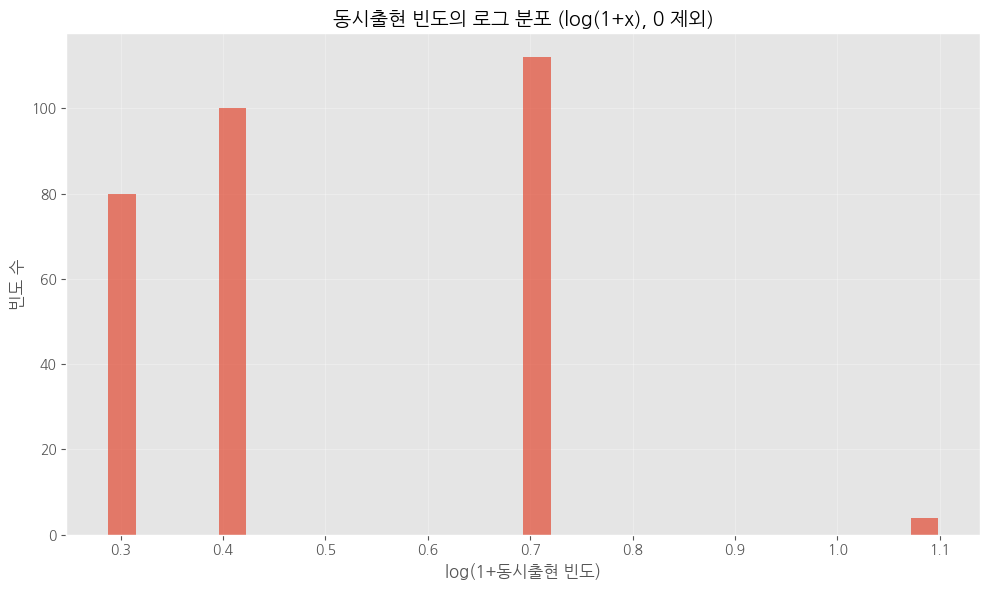

윈도우 크기: 5
동시출현 행렬 통계:
  총 동시출현 빈도: 219.67
  0이 아닌 원소 수: 396
  최대값: 2.00
  최소값 (0 제외): 0.20
  평균값 (0 제외): 0.55
  중앙값 (0 제외): 0.50


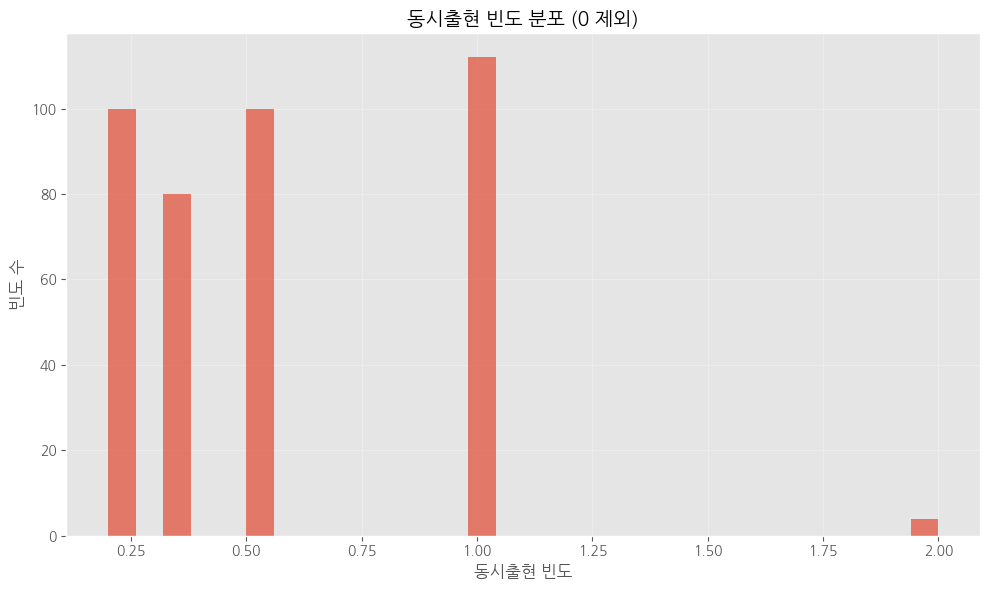

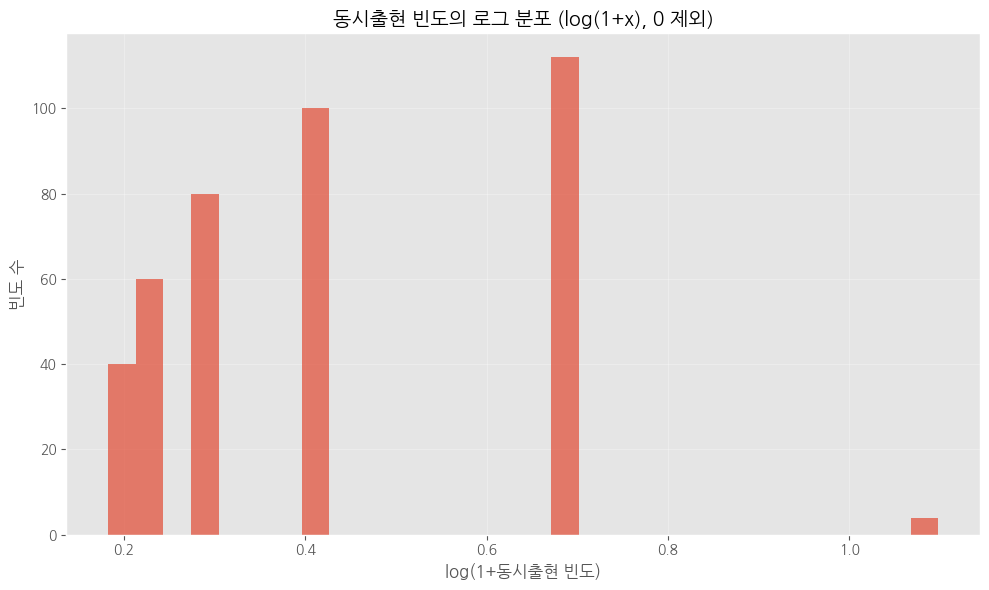

In [15]:
def analyze_cooccurrence_matrix(cooccurrence_matrix):
    """동시출현 행렬의 특성을 분석하는 함수

    Args:
        cooccurrence_matrix: 동시출현 행렬
    """
    # 행렬을 밀집 형태로 변환 (메모리 사용량 주의)
    dense_matrix = cooccurrence_matrix.toarray()

    # 기본 통계량
    non_zero_values = dense_matrix[dense_matrix > 0]

    print("동시출현 행렬 통계:")
    print(f"  총 동시출현 빈도: {cooccurrence_matrix.sum():.2f}")
    print(f"  0이 아닌 원소 수: {len(non_zero_values)}")
    print(f"  최대값: {non_zero_values.max():.2f}")
    print(f"  최소값 (0 제외): {non_zero_values.min():.2f}")
    print(f"  평균값 (0 제외): {non_zero_values.mean():.2f}")
    print(f"  중앙값 (0 제외): {np.median(non_zero_values):.2f}")

    # 동시출현 빈도 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(non_zero_values, bins=30, alpha=0.7)
    plt.title("동시출현 빈도 분포 (0 제외)", fontsize=14)
    plt.xlabel("동시출현 빈도", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 로그 스케일 분포 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(np.log1p(non_zero_values), bins=30, alpha=0.7)
    plt.title("동시출현 빈도의 로그 분포 (log(1+x), 0 제외)", fontsize=14)
    plt.xlabel("log(1+동시출현 빈도)", fontsize=12)
    plt.ylabel("빈도 수", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 동시출현 행렬 분석 (행렬 크기가 작을 때만 실행)
vocab_size = len(word_to_id)
for window_size in window_sizes:
  print(f"윈도우 크기: {window_size}")
  cooccurrence_matrix_glove = build_cooccurrence_matrix_glove(tokenized_corpus, word_to_id, window_size)
  if vocab_size <= 1000:  # 어휘 크기가 너무 크면 메모리 문제 발생 가능
      analyze_cooccurrence_matrix(cooccurrence_matrix_glove)
  else:
      print(f"어휘 크기({vocab_size})가 너무 커서 동시출현 행렬 분석을 건너뜁니다.")

## 3.6 결과 저장

다음 단계인 GloVe 손실 함수 구현을 위해 동시출현 행렬을 저장합니다.

In [ ]:
# 결과 저장
glove_matrix_results = {
    'cooccurrence_matrix': cooccurrence_matrix_glove,
    'window_size': window_size
}

with open('glove_matrix_results.pkl', 'wb') as f:
    pickle.dump(glove_matrix_results, f)

print("GloVe 동시출현 행렬 결과가 'glove_matrix_results.pkl' 파일에 저장되었습니다.")

GloVe 동시출현 행렬 결과가 'glove_matrix_results.pkl' 파일에 저장되었습니다.


## 3.7 요약 및 다음 단계

이 노트북에서는 GloVe 모델을 위한 동시출현 행렬을 구축하고 분석했습니다. 주요 단계는 다음과 같습니다:

1. 윈도우 기반 동시출현 행렬 구축
2. 희소 행렬을 사용하여 메모리 효율적으로 저장
3. 동시출현 패턴 시각화 및 분석
4. 특정 단어와 가장 자주 동시출현하는 단어 찾기
5. 동시출현 행렬의 특성 분석

동시출현 행렬은 GloVe 모델의 핵심 입력 데이터입니다. 이 행렬의 특성과 패턴을 이해하는 것은 워드 임베딩의 품질을 개선하는 데 중요합니다.

다음 노트북에서는 이 동시출현 행렬을 사용하여 GloVe 손실 함수를 구현하고 단어 임베딩을 학습합니다.

## 연습 문제

1. 다양한 윈도우 크기(1, 3, 5 등)에 대한 동시출현 행렬을 구축하고 결과를 비교해보세요.
2. 거리에 따른 가중치 계산 방식을 변경해보세요 (예: 지수 감소, 선형 감소).
3. 특정 주제와 관련된 단어들의 동시출현 패턴을 분석해보세요.